In [1]:
import numpy as np

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline


# Numerical integration

We are want to solve problems of the form

$$\frac{d\mathbf{y}}{dt} = \mathbf{f}(t, \mathbf{y})$$

where $\mathbf{y}$ is a vector of unknowns.  We can do this by discretizing time.

### Relationship to optimization

+ Every optimization problem can be written as an ODE for potential flow. However, not every ODE can be written as an optimization problem.
+ Limit cycles, chaos, and other interesting phenomena can be found in ODEs, but not in optimization problems, because potential flows have zero curl.
+ While we cannot always define a potential function for a given set of ODEs, the gradient and the Hessian are still well-defined. In an ODE context, the gradient is just the right-hand side of the ODE, $\frac{d\mathbf{y}}{dt}$, and the Hessian corresponds to the Jacobian matrix of the right-hand side.

$$
\mathbb{J} = \frac{\partial \dot{\mathbf{y}}}{\partial \mathbf{y}} = \frac{\partial \mathbf{f}}{\partial \mathbf{y}}
$$

Writing this out,
$$
\mathbb{J} = \begin{bmatrix}
\frac{\partial f_1}{\partial y_1} & \frac{\partial f_1}{\partial y_2} & \cdots & \frac{\partial f_1}{\partial y_n} \\
\frac{\partial f_2}{\partial y_1} & \frac{\partial f_2}{\partial y_2} & \cdots & \frac{\partial f_2}{\partial y_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial f_n}{\partial y_1} & \frac{\partial f_n}{\partial y_2} & \cdots & \frac{\partial f_n}{\partial y_n}
\end{bmatrix}
$$

Just as we saw in optimization, stepping the right-hand side is always necessary to find the next step in the solution. Knowledge of the Jacobian can improve convergence and stability, as well as reveal mathemtical properties of the ODE solution.

<!-- $$
\frac{d\mathbf{y}}{dt} = \mathbb{J} \mathbf{y} -->

# The Thomas Model

Let's use a well-known set of coupled differential equations to demonstrate our numerical integration schemes
$$
\dot{x} = \sin(y) - b x     \\
\dot{y} = \sin(z) - b y     \\
\dot{z} = \sin(x) - b z     \\
$$
These equations describe the motion of a particle confined in a 3D harmonic potential, subject to a periodic lattice of dispersive forces.


### An initial value problem

In numerical integration, we are usually given an initial condition $\mathbf{x}(0)$ and asked to find $\mathbf{x}(t)$ for some $t > 0$. 



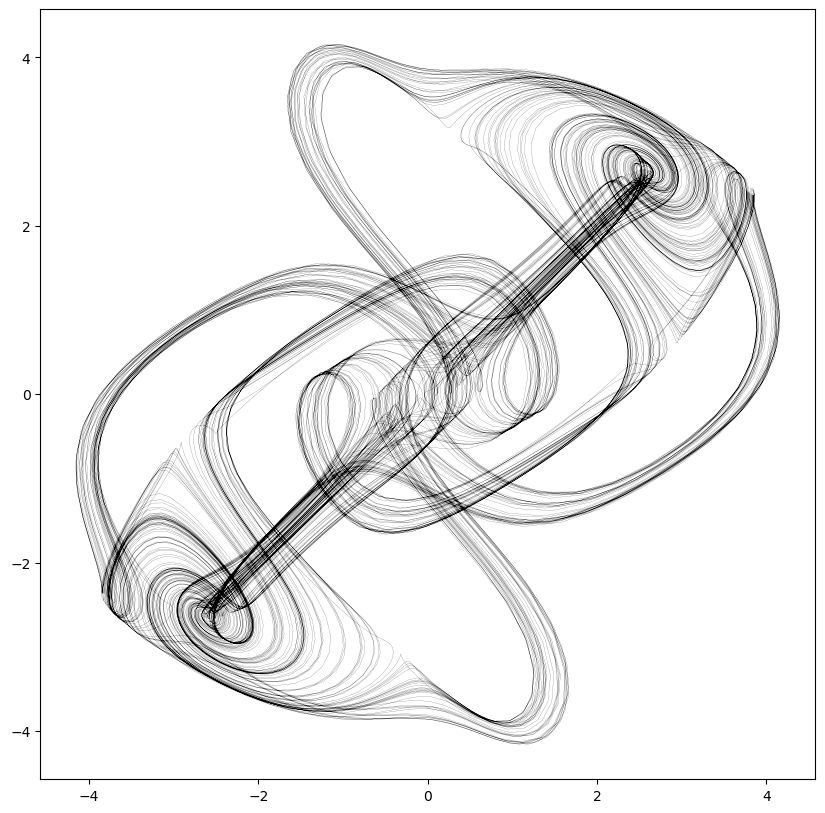

In [2]:
def thomas_model(t, X, b=0.185):
    """
    Thomas dynamical model
    """
    x, y, z = X
    xdot = np.sin(y) - b * x
    ydot = np.sin(z) - b * y
    zdot = np.sin(x) - b * z
    return np.array([xdot, ydot, zdot])

def lorenz_model(t, X, sigma=10, rho=28, beta=8/3):
    """
    Lorenz dynamical model
    """
    x, y, z = X
    xdot = sigma * (y - x)
    ydot = x * (rho - z) - y
    zdot = x * y - beta * z
    return np.array([xdot, ydot, zdot])



# Let's cheat and integrate the ODE using scipy.integrate.solve_ivp
from scipy.integrate import solve_ivp
ic = [0.21, 0.3, 0.4]
t = np.linspace(0, 6000, 17000)
sol = solve_ivp(thomas_model, [t[0], t[-1]], ic, t_eval=t)
X = sol.y.T


plt.figure(figsize=(10, 10))
plt.plot(X[:, 0], X[:, 1], linewidth=0.1, color='k', alpha=1.0)

## Reference trajectory from scipy.integrate.solve_ivp

+ Note: some Python users might use `scipy.integrate.odeint` instead of `scipy.integrate.solve_ivp`.  The latter is more general and arguably more powerful, but the former is more widely used.

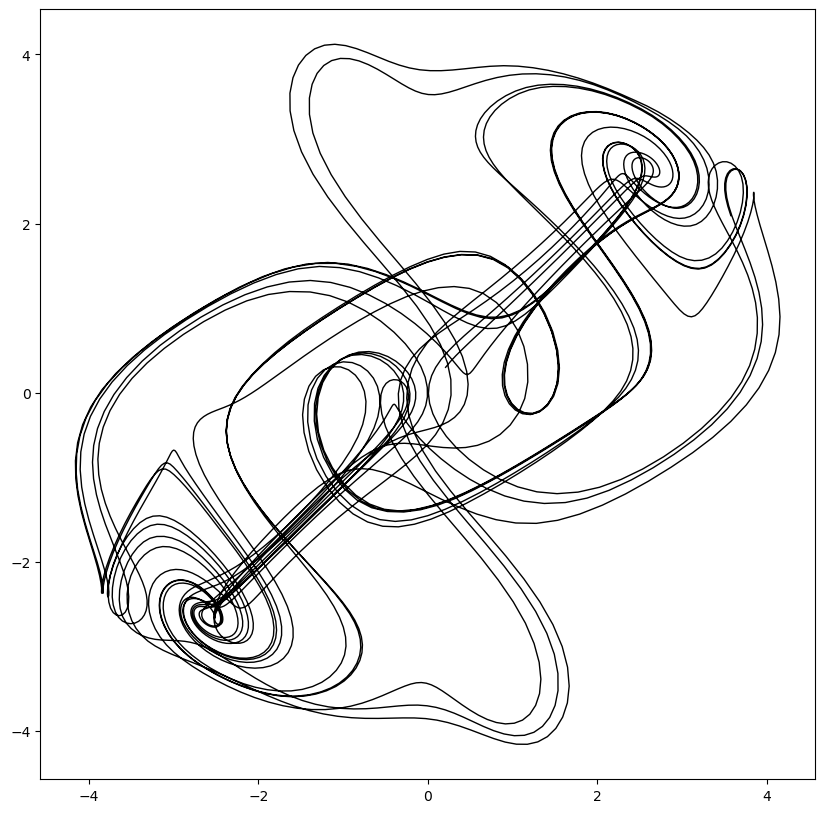

In [3]:
# Let's cheat and integrate the ODE using scipy.integrate.solve_ivp
from scipy.integrate import solve_ivp
ic = [0.21, 0.3, 0.4]
t = np.linspace(0, 600, 3000)
sol = solve_ivp(thomas_model, [t[0], t[-1]], ic, t_eval=t)
X = sol.y.T


plt.figure(figsize=(10, 10))
plt.plot(X[:, 0], X[:, 1], linewidth=1, color='k')

## Explicit fixed-step integrators

+ The Euler method is the simplest explicit fixed-step integrator. It is a first-order method, and is unconditionally stable for a sufficiently small step size. It is also the most computationally efficient method per evaluation, but it is also the least accurate.

$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}(t_n, \mathbf{x}_n)
$$

+ The Runge-Kutta method is a second-order method, and is unconditionally stable for a sufficiently small step size. It is more computationally expensive than the Euler method, but it is also more accurate.

In [4]:
class BaseFixedStepIntegrator:
    """
    A base class for fixed-step integration methods.
    """
    def __init__(self, dt=1e-3):
        self.dt = dt
        self.name = self.__class__.__name__
        
    def integrate(self, f, tspan, y0, t_eval=None):
        """
        Integrate the ODE y' = f(t, y) from t0 to tf using an integrator's update method
        """
        t0, tf = tspan
        # Create an array of time points to evaluate the solution
        if t_eval is None:
            t_eval = np.arange(t0, tf, self.dt)

        # Create an array to store the solution (pre-allocate)
        y = np.zeros((len(t_eval), len(y0)))

        # Set the initial condition
        y[0] = y0

        # Integrate the ODE
        for i in range(1, len(t_eval)):
            t = t_eval[i - 1]
            y[i] = self.update(f, t, y[i - 1]) # this will be defined in the subclass

        self.t, self.y = t_eval, np.array(y)
        return self

    def update(self, f, t, y):
        """
        Update the solution using the integrator's method
        """
        raise NotImplementedError("This method must be implemented in a subclass")
        

class Euler(BaseFixedStepIntegrator):
    """
    Note:
    super() calls the constructor of BaseIntegrator
    kwargs get passed on to the constructor of BaseIntegrator
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def update(self, f, t, y):
        return y + self.dt * f(t, y)

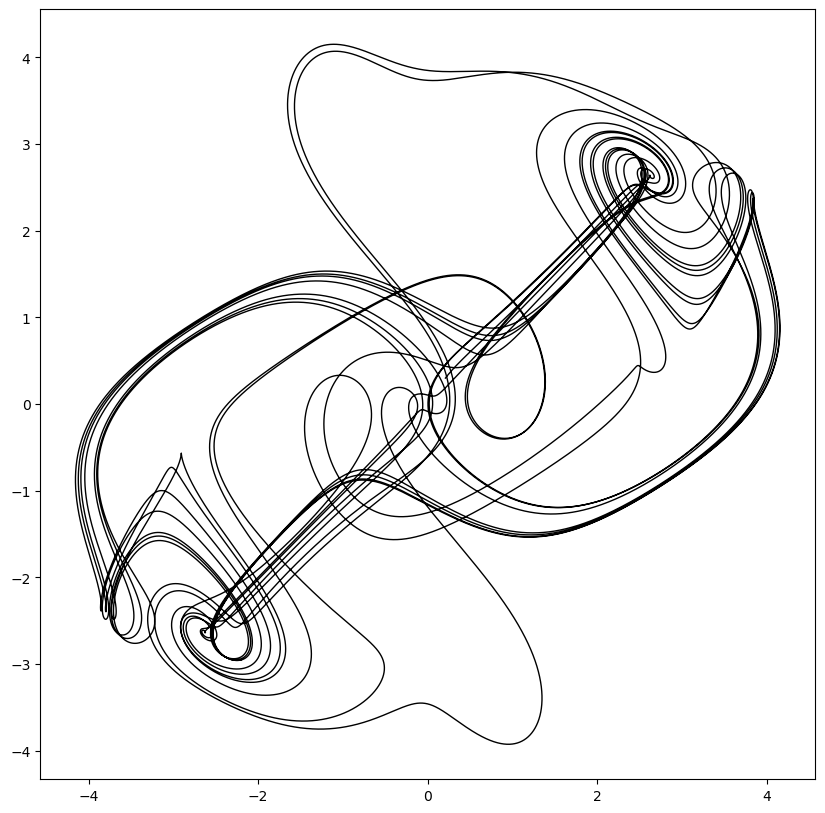

In [7]:
integrator = Euler(dt=0.001)

ic = np.array([0.21, 0.3, 0.4])
t = np.linspace(0, 600, 3000)
sol = integrator.integrate(thomas_model, [t[0], t[-1]], ic)

plt.figure(figsize=(10, 10))
plt.plot(sol.y[:, 0], sol.y[:, 1], linewidth=1, color='k')

### Consider: 

1. How does the Euler method fail at large step sizes
2. What if we try another dynamical system? What kinds of things happen?

# Runge-Kutta Methods

+ Runge-Kutta methods require more evaluations of the right hand side function $\mathbf{f}$ to compute each timestep, but have greater stability and accuracy in exchange
+ An entire family of methods, parametrized by the number of evaluations of $\mathbf{f}$, the points at which these evaluations are made, and the weights used to combine the evaluations.

### The Modifed Euler method

+ The Modified Euler method is more computationally expensive than the Euler method, but it is also more accurate.

$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}\left(t_n + \frac{\Delta t}{2},\; \mathbf{x}_n + \frac{\Delta t}{2} \mathbf{f}(t_n, \mathbf{x}_n)\right)
$$


In [8]:
class ModifiedEuler(BaseFixedStepIntegrator):
    """
    The modified Euler method is a second-order method, so it is more accurate than the 
    Euler method.
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def update(self, f, t, y):
        k1 = f(t, y)
        k2 = f(t + self.dt, y + self.dt * k1)
        return y + self.dt * (k1 + k2) / 2

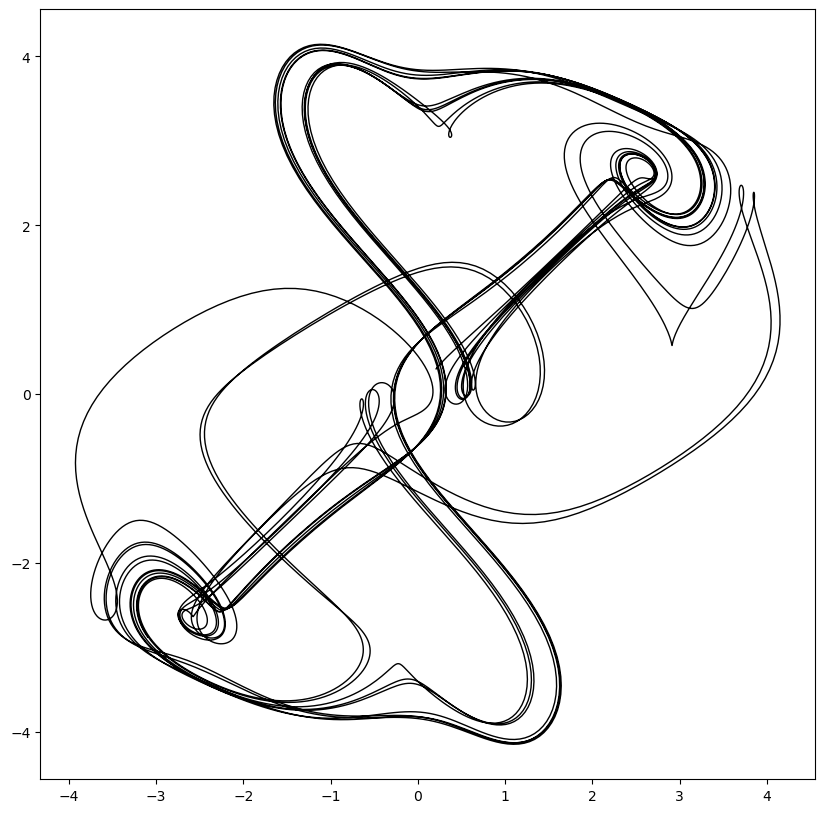

In [10]:
integrator = ModifiedEuler(dt=0.1)

ic = np.array([0.21, 0.3, 0.4])
t = np.linspace(0, 600, 3000)
sol = integrator.integrate(thomas_model, [t[0], t[-1]], ic)

plt.figure(figsize=(10, 10))
plt.plot(sol.y[:, 0], sol.y[:, 1], linewidth=1, color='k')

Some other methods to consider:

### Heun's method is RK2(3)


Heun's method is like a forward/explicit trapezoidal rule

$$
\tilde{\mathbf{x}}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}(t_n, \mathbf{x}_n) \\
$$
$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \frac{1}{2}\left(\mathbf{f}(t_n, \mathbf{x}_n) + \mathbf{f}(t_{n+1}, \tilde{\mathbf{x}}_{n+1})\right)
$$

### Ralston's method is RK3(4)

Ralston's method is a third-order method that is more accurate than Heun's method

$$
\begin{align}
k_1 &= \mathbf{f}(t_n, \mathbf{x}_n) \\
k_2 &= \mathbf{f}\left(t_n + \frac{\Delta t}{4}, \mathbf{x}_n + \frac{\Delta t}{4} k_1\right) \\
k_3 &= \mathbf{f}\left(t_n + \frac{3\Delta t}{4}, \mathbf{x}_n + \frac{3\Delta t}{4} k_2\right) \\
\mathbf{x}_{n+1} &= \mathbf{x}_n + \frac{\Delta t}{9}\left(2 k_1 + 3 k_2 + 4 k_3\right)
\end{align}
$$


### Fourth-order Runge-Kutta or RK4(5)

RK4 is the default solver in some older black box solvers, although Dormand-Prince is more common these days

$$
\begin{align}
k_1 &= \mathbf{f}(t_n, \mathbf{x}_n) \\
k_2 &= \mathbf{f}\left(t_n + \frac{\Delta t}{2}, \mathbf{x}_n + \frac{\Delta t}{2} k_1\right) \\
k_3 &= \mathbf{f}\left(t_n + \frac{\Delta t}{2}, \mathbf{x}_n + \frac{\Delta t}{2} k_2\right) \\
k_4 &= \mathbf{f}\left(t_n + \Delta t, \mathbf{x}_n + \Delta t k_3\right) \\
\mathbf{x}_{n+1} &= \mathbf{x}_n + \frac{\Delta t}{6}\left(k_1 + 2 k_2 + 2 k_3 + k_4\right)
\end{align}
$$

### ... and many more

In [16]:
class Heun(BaseFixedStepIntegrator):
    """
    The Heun method for integration
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def update(self, f, t, y):
        k1 = f(t, y)
        k2 = f(t + self.dt, y + self.dt * k1)
        return y + self.dt * (k1 + k2) / 2

class Ralston(BaseFixedStepIntegrator):
    """
    The Ralston method for integration
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def update(self, f, t, y):
        k1 = f(t, y)
        k2 = f(t + self.dt / 2, y + self.dt * k1 / 2)
        return y + self.dt * k2

class RK4(BaseFixedStepIntegrator):
    """
    The Runge-Kutta 4 method for integration
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def update(self, f, t, y):
        k1 = f(t, y)
        k2 = f(t + self.dt / 2, y + self.dt * k1 / 2)
        k3 = f(t + self.dt / 2, y + self.dt * k2 / 2)
        k4 = f(t + self.dt, y + self.dt * k3)
        return y + self.dt * (k1 + 2 * k2 + 2 * k3 + k4) / 6

class RK7(BaseFixedStepIntegrator):
    """
    The Runge-Kutta 10 method for integration
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def update(self, f, t, y):
        k1 = f(t, y)
        k2 = f(t + self.dt / 5, y + self.dt * k1 / 5)
        k3 = f(t + self.dt * 3 / 10, y + self.dt * (3 * k1 / 40 + 9 * k2 / 40))
        k4 = f(t + self.dt * 4 / 5, y + self.dt * (44 * k1 / 45 - 56 * k2 / 15 + 32 * k3 / 9))
        k5 = f(t + self.dt * 8 / 9, y + self.dt * (19372 * k1 / 6561 - 25360 * k2 / 2187 + 64448 * k3 / 6561 - 212 * k4 / 729))
        k6 = f(t + self.dt, y + self.dt * (9017 * k1 / 3168 - 355 * k2 / 33 + 46732 * k3 / 5247 + 49 * k4 / 176 - 5103 * k5 / 18656))
        k7 = f(t + self.dt, y + self.dt * (35 * k1 / 384 + 500 * k3 / 1113 + 125 * k4 / 192 - 2187 * k5 / 6784 + 11 * k6 / 84))
        return y + self.dt * (35 * k1 / 384 + 500 * k3 / 1113 + 125 * k4 / 192 - 2187 * k5 / 6784 + 11 * k6 / 84)


Text(0.5, 1.0, 'scipy.integrate.solve_ivp')

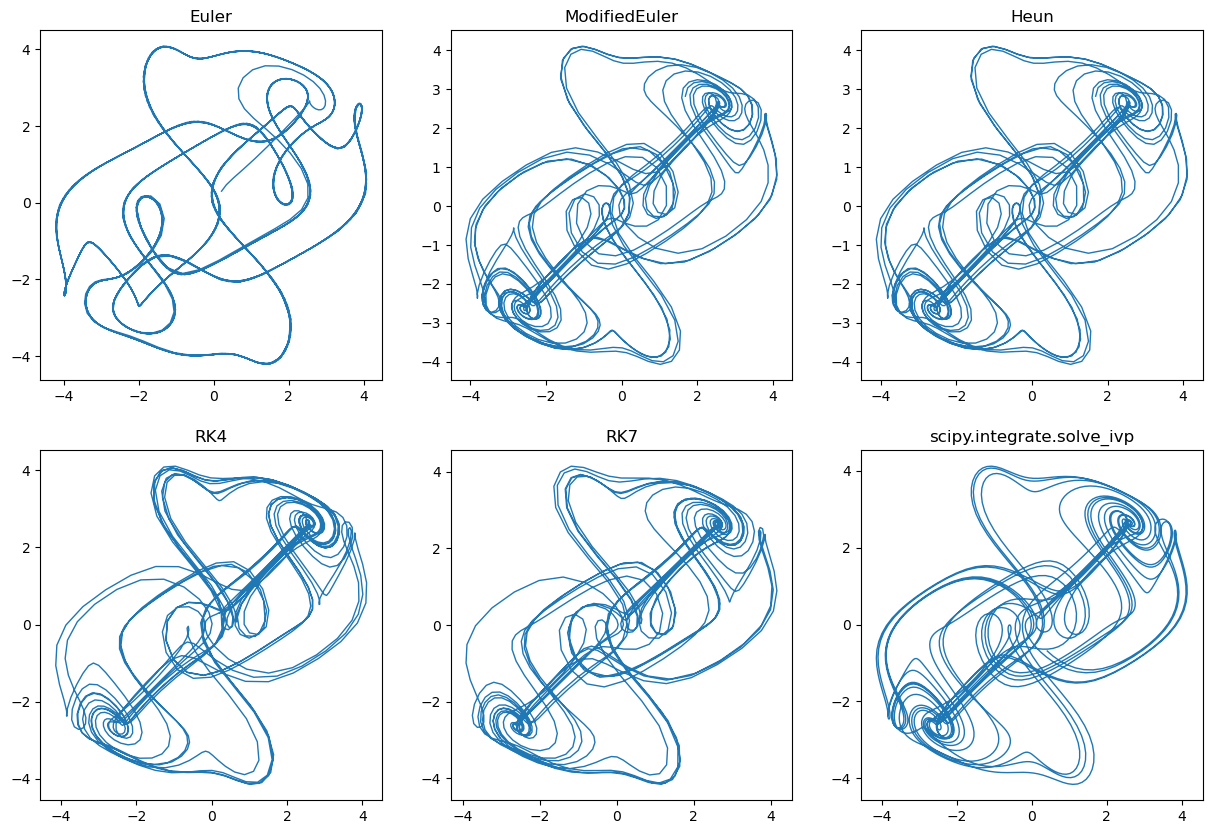

In [36]:
dt_val = 0.5
system = thomas_model 
# system = lorenz_model
ic = np.array([0.21, 0.3, 0.4])
t = np.linspace(0, 600, 3000)

plt.figure(figsize=(15, 10))

integrator = Euler(dt=dt_val)
sol = integrator.integrate(system, [t[0], t[-1]], ic)
plt.subplot(2, 3, 1)
plt.plot(sol.y[:, 0], sol.y[:, 1], linewidth=1)
plt.title(integrator.name)

integrator = ModifiedEuler(dt=dt_val)
sol = integrator.integrate(system, [t[0], t[-1]], ic)
plt.subplot(2, 3, 2)
plt.plot(sol.y[:, 0], sol.y[:, 1], linewidth=1)
plt.title(integrator.name)

integrator = Heun(dt=dt_val)
sol = integrator.integrate(system, [t[0], t[-1]], ic)
plt.subplot(2, 3, 3)
plt.plot(sol.y[:, 0], sol.y[:, 1], linewidth=1)
plt.title(integrator.name)

# integrator = Ralston(dt=dt_val)
# sol = integrator.integrate(system, [t[0], t[-1]], ic)
# plt.subplot(2, 3, 4)
# plt.plot(sol.y[:, 0], sol.y[:, 1], linewidth=1)
# plt.title(integrator.name)

integrator = RK4(dt=dt_val)
sol = integrator.integrate(system, [t[0], t[-1]], ic)
plt.subplot(2, 3, 4)
plt.plot(sol.y[:, 0], sol.y[:, 1], linewidth=1)
plt.title(integrator.name)

integrator = RK7(dt=dt_val)
sol = integrator.integrate(system, [t[0], t[-1]], ic)
plt.subplot(2, 3, 5)
plt.plot(sol.y[:, 0], sol.y[:, 1], linewidth=1)
plt.title(integrator.name)

sol = solve_ivp(system, [t[0], t[-1]], ic, t_eval=t, method='Radau')
plt.subplot(2, 3, 6)
plt.plot(sol.y[0, :], sol.y[1, :], linewidth=1)
plt.title('scipy.integrate.solve_ivp')




## Butcher Tableau

A recursive set of definitions for the coefficients in explicit Runge-Kutta methods

#### Generic Runge-Kutta methods

$$
k_{ni} = \mathbf{f}\left(t_n + c_i \Delta t,\;\; \mathbf{x}_n + \Delta t \sum_{j=1}^s a_{ij} k_{nj}\right)
$$

The Butcher tableau is a table that summarizes the coefficients of the method

$$
\begin{array} {c|ccccc} 0\\ c_2 & a_{21}\\ c_3 & a_{31} & a_{32} \\ \vdots & \vdots & & \ddots \\ c_s& a_{s1}& a_{s2} & \cdots & a_{s,s-1}\\ \hline & b_1 & b_2 & \cdots & b_{s-1} & b_s \end{array}
$$

We read the Butcher Tableau from bottom to top, starting with the final step, and then going up the table to see how each step is constructed from the previous steps. However, computationally, we traverse the table from top to bottom. The all-zero row always corresponds to the forward Euler step, which serves as a base case for the recursion

Each column tells us how much to weight the output of the corresponding previous row when computing that row.


#### Euler's method (forward step)

$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}(t_n, \mathbf{x}_n)
$$

\begin{array} 
{c|c} 0 & 0\\ \hline & 1
\end{array}

<!-- #### Euler's method (backward step)

$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}(t_{n+1}, \mathbf{x}_{n+1})
$$

\begin{array} 
{c|c} 1 & 1\\ \hline & 1
\end{array} -->

#### Modified Euler's method

$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}\left(t_n + \frac{\Delta t}{2},\; \mathbf{x}_n + \frac{\Delta t}{2} \mathbf{f}(t_n, \mathbf{x}_n)\right)
$$

\begin{array}
{c|cc} 0 & 0 & 0\\ \frac{1}{2} & \frac{1}{2} & 0\\ \hline & 0 & 1
\end{array}


#### Heun's method

$$
\tilde{\mathbf{x}}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}(t_n, \mathbf{x}_n) \\
$$
$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \frac{1}{2}\left(\mathbf{f}(t_n, \mathbf{x}_n) + \mathbf{f}(t_{n+1}, \tilde{\mathbf{x}}_{n+1})\right)
$$

\begin{array}
{c|cc} 0 & 0 & 0\\ 1 & 1 & 0\\ \hline & 1/2 & 1/2
\end{array}

#### Ralston's method


$$
\begin{align}
k_1 &= \mathbf{f}(t_n, \mathbf{x}_n) \\
k_2 &= \mathbf{f}\left(t_n + \frac{\Delta t}{4}, \mathbf{x}_n + \frac{\Delta t}{4} k_1\right) \\
k_3 &= \mathbf{f}\left(t_n + \frac{3\Delta t}{4}, \mathbf{x}_n + \frac{3\Delta t}{4} k_2\right) \\
\mathbf{x}_{n+1} &= \mathbf{x}_n + \frac{\Delta t}{9}\left(2 k_1 + 3 k_2 + 4 k_3\right)
\end{align}
$$

\begin{array}
{c|ccc} 0 & 0 & 0 & 0\\ 1/4 & 1/4 & 0 & 0\\ 3/4 & 0 & 3/4 & 0\\ \hline & 2/9 & 3/9 & 4/9
\end{array}

#### RK4

$$
\begin{align}
k_1 &= \mathbf{f}(t_n, \mathbf{x}_n) \\
k_2 &= \mathbf{f}\left(t_n + \frac{\Delta t}{2}, \mathbf{x}_n + \frac{\Delta t}{2} k_1\right) \\
k_3 &= \mathbf{f}\left(t_n + \frac{\Delta t}{2}, \mathbf{x}_n + \frac{\Delta t}{2} k_2\right) \\
k_4 &= \mathbf{f}\left(t_n + \Delta t, \mathbf{x}_n + \Delta t k_3\right) \\
\mathbf{x}_{n+1} &= \mathbf{x}_n + \frac{\Delta t}{6}\left(k_1 + 2 k_2 + 2 k_3 + k_4\right)
\end{align}
$$


\begin{array}
{c|cccc} 0 & 0 & 0 & 0 & 0\\ 1/2 & 1/2 & 0 & 0 & 0\\ 1/2 & 0 & 1/2 & 0 & 0\\ 1 & 0 & 0 & 1 & 0\\ \hline & 1/6 & 1/3 & 1/3 & 1/6
\end{array}



<!-- \begin{array} {c|ccccc} c_1 & a_{11} & a_{12} & \cdots & a_{1s} \\ c_2 & a_{21} & a_{22} & \cdots & a_{2s} \\ \vdots & \vdots & & \ddots & \vdots \\ c_s& a_{s1}& a_{s2} & \cdots & a_{s,s}\\ \hline & b_1 & b_2 & \cdots & b_{s} \end{array}


Notes here:
https://www.johndcook.com/blog/2020/02/13/runge-kutta-methods/ -->

### Convergence and stability of ODE solvers

The global error of a solver at a given step is given by
$$
e_n = || \mathbf{x}_{n} - \mathbf{X}(t_{n})||
$$
where $\mathbf{X}(t_{n})$ is the exact solution at that time step. 

We can define the *truncation error* for a fixed-step solver with step size $\Delta t$ as
$$
T_n = \dfrac{\mathbf{x}_{n+1} - \mathbf{x_n}}{\Delta t} - \mathbf{f}(t_n, \mathbf{X}(t_{n}))
$$
Where we've applied the right hand side of the ODE to the *exact* solution to get the exact derivative at that time step.

The *local error* is therefore given by
$$
L_n = \Delta t \; ||T_n||
$$

This measures the local error introduced during a single timestep, under a linear approximation of the ODE.




### Global error accumulates from local error

The global error is given by
$$
e_n = || \mathbf{x}_{n} - \mathbf{X}(t_{n})||
$$
where $\mathbf{X}(t_{n})$ is the exact solution at that time step. The global error at the next step is given by
$$
e_{n+1} = || \mathbf{x}_{n+1} - \mathbf{X}(t_{n+1})||
$$

We can use the Taylor series expansion of the exact solution, and of the numerical solution, to write
$$
\mathbf{X}(t_{n+1}) = \mathbf{X}(t_{n}) + \Delta t \mathbf{X}'(t_{n}) + \frac{\Delta t^2}{2} \mathbf{X}''(t_{n}) + \cdots
$$
$$
\mathbf{x}_{n+1} = \mathbf{x}_{n} + \Delta t \mathbf{f}(t_n, \mathbf{x}_n) + \frac{\Delta t^2}{2} \mathbf{f}'(t_n, \mathbf{x}_n) + \cdots
$$

Substituting both expansions into the global error at the next step, we get

$$
e_{n+1} = || \mathbf{x}_{n} + \Delta t \mathbf{f}(t_n, \mathbf{x}_n) + \frac{\Delta t^2}{2} \mathbf{f}'(t_n, \mathbf{x}_n) + \cdots - \mathbf{X}(t_{n}) - \Delta t \mathbf{X}'(t_{n}) - \frac{\Delta t^2}{2} \mathbf{X}''(t_{n}) - \cdots||
$$

Rearranging terms,

$$
e_{n+1} = || \bigg(\mathbf{x}_{n} - \mathbf{X}(t_{n})\bigg) + \Delta t \bigg(\mathbf{f}(t_n, \mathbf{x}_n) - \mathbf{X}'(t_{n})\bigg) + \frac{\Delta t^2}{2} \bigg( \mathbf{f}'(t_n, \mathbf{x}_n) - \mathbf{X}''(t_{n})\bigg) + \cdots ||
$$


Now, let's assume that $\mathbf{f}$ satisfies a Lifshitz condition, which means that the derivative of $\mathbf{f}$ is Lipschitz continuous with respect to the solution. This means that the derivative of $\mathbf{f}$ is bounded by a constant $L$ in terms of the solution. Then we can write

$$
|\mathbf{f}(t, u) - \mathbf{f}(t, v)| \leq L ||u - v|| |
$$

Where $L$ is a constant called the Lifshitz constant. This means that the derivative of $\mathbf{f}$ is bounded by a constant $L$. If we have a simple right hand side, then we can calculate the Lifshitz constant as the maximum of the gradient on the domain of the problem, for all values of $t$. However, even non-differentiable functions can satisfy a Lifshitz condition.


## Multistep methods

Idea: Combine past steps to get a better estimate of the current step. Common methods are Adams-Bashforth and Adams-Moulton, as well as BDF (backward differentiation formula). The latter is a workhorse method for stiff ODEs that is included in SciPy's `solve_ivp` function.

In [ ]:
class AdamsBashforth(BaseFixedStepIntegrator):
    """
    The Adams-Bashforth method for integration
    """
    def __init__(self, order=2, **kwargs):
        super().__init__(**kwargs)
        self.order = order
        self._k = np.zeros((order, self.n))
        
    def update(self, f, t, y):
        self._k[1:, :] = self._k[:-1, :]
        self._k[0, :] = f(t, y)
        return y + self.dt * np.sum(self._k, axis=0) / np.arange(1, self.order + 1).cumprod()

## Implicit Integration

Implicit integration methods are methods that solve ODE using iterations of the form

$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}(t_{n+1}, \mathbf{x}_{n+1})
$$

Because $\mathbf{x}_{n+1}$ appears on both sides of the equation, we need to solve for it. This is therefore a nonlinear equation in $\mathbf{x}_{n+1}$. We can group terms in $\mathbf{x}_{n+1}$ on one side of our expression.

$$
\mathbf{x}_{n+1}  - \Delta t\; \mathbf{f}(t_{n+1}, \mathbf{x}_{n+1}) = \mathbf{x}_n
$$

This is a nonlinear equation in $\mathbf{x}_{n+1}$, which we can solve for using Newton's method, or a similar method. The Newton method is a root-finding algorithm that uses the first-order Taylor expansion of the function to find the root. The Newton method is given by

$$
\mathbf{x}_{n+1} = \mathbf{x}_n - \mathbf{J}(t_{n+1}, \mathbf{x}_{n+1})^{-1} \;\;\mathbf{f}(t_{n+1}, \mathbf{x}_{n+1})
$$
re-writing this in terms of $\mathbf{x}_{n}$ gives us
$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t \left(\mathbb{I} - \Delta t J(t_{n}, \mathbf{x}_{n})\right)^{-1} \;\;\mathbf{f}(t_{n}, \mathbf{x}_{n})
$$

where $\mathbf{J}$ is the Jacobian of $\mathbf{f}$.

where $\mathbf{J}(t_{n+1}, \mathbf{x}_{n+1})$ is the Jacobian of $\mathbf{f}$ at $(t_{n+1}, \mathbf{x}_{n+1})$. The Newton method is a fixed-point iteration, and is guaranteed to converge to a root of $\mathbf{f}$ if the Jacobian is invertible. The Newton method is a special case of the Newton-Krylov method, which is a generalization of the Newton method that uses a Krylov subspace method to solve the linear system $\mathbf{J}(t_{n+1}, \mathbf{x}_{n+1})\mathbf{y} = -\mathbf{f}(t_{n+1}, \mathbf{x}_{n+1})$.

where $\mathbf{f}'$ is the Jacobian of $\mathbf{f}$.

where $\mathbf{J}(t_{n+1}, \mathbf{x}_{n+1})$ is the Jacobian of $\mathbf{f}$ evaluated at $\mathbf{x}_{n+1}$. The Newton-Raphson method is a fixed-point iteration method, which means that we iterate on the right-hand side of the equation until we converge to a solution. The Newton-Raphson method is given by


which we can solve for $\mathbf{x}_{n+1}$ using Newton's method. The Jacobian of the function is

$$
\mathbf{J} = \frac{\partial \mathbf{f}}{\partial \mathbf{x}} = \frac{\partial \mathbf{f}}{\partial \mathbf{x}} + \frac{\partial \mathbf{f}}{\partial t}\frac{\partial t}{\partial \mathbf{x}} = \mathbf{I} + \Delta t\; \frac{\partial \mathbf{f}}{\partial \mathbf{x}}
$$

where $\mathbf{I}$ is the identity matrix. The Newton update is

$$
\mathbf{x}_{n+1} = \mathbf{x}_n - \mathbf{J}^{-1}\mathbf{f}(t_{n+1}, \mathbf{x}_{n+1})
$$

The Jacobian is a square matrix of size $n$, where $n$ is the number of equations in the ODE. This means that the Newton update is an $n \times n$ matrix multiplication, which is expensive. However, we can use a linear solver to solve the linear system of equations. This is the approach taken by SciPy's `solve_ivp` function.

<!-- $$
\mathbf{J} = \frac{\partial \mathbf{f}}{\partial \mathbf{x}} = \frac{\partial \mathbf{f}}{\partial \mathbf{x}}(t_{n+1}, \mathbf{x}_{n+1})
$$ -->

The Newton update is

$$
\mathbf{x}_{n+1} = \mathbf{x}_{n} - \mathbf{J}^{-1} \mathbf{f}(t_{n+1}, \mathbf{x}_{n+1})
$$

The Newton update is repeated until the residual $\mathbf{f}$ is small enough. The Newton update is also known as the Picard iteration.

### Newton's method

$$
\mathbf{x}_{n+1} = \mathbf{x}_{n+1} - \mathbf{J}^{-1} \mathbf{f}(t_{n+1}, \mathbf{x}_{n+1})
$$

### Picard iteration

$$
\mathbf{x}_{n+1} = \mathbf{x}_{n+1} - \mathbf{f}(t_{n+1}, \mathbf{x}_{n+1})
$$

<!-- $$
\mathbf{J} = \frac{\partial \mathbf{f}}{\partial \mathbf{x}} = \mathbf{I} + \Delta t\; \frac{\partial \mathbf{f}}{\partial \mathbf{x}}(t_{n+1}, \mathbf{x}_{n+1})
$$

The Newton update is

$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}(t_{n+1}, \mathbf{x}_{n+1}) + \Delta t\; \mathbf{J}^{-1}\left(\mathbf{x}_{n+1} - \mathbf{x}_n - \Delta t\; \mathbf{f}(t_{n+1}, \mathbf{x}_{n+1})\right)
$$ -->


## The implicit Euler method

The implicit, or backward, Euler method is a special case of the Newton-Krylov method, where the Jacobian is the identity matrix. We start with our standard implicit solution:

$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}(t_{n+1}, \mathbf{x}_{n+1})
$$

We solve this equation by using the Newton-Krylov method, where the Jacobian is the identity matrix:

$$
\mathbf{x}_{n+1} = \mathbf{x}_n + \Delta t\; \mathbf{f}(t_{n+1}, \mathbf{x}_{n+1}) + \Delta t\; \mathbf{J}^{-1}\left(\mathbf{x}_{n+1} - \mathbf{x}_n - \Delta t\; \mathbf{f}(t_{n+1}, \mathbf{x}_{n+1})\right)



where $\mathbf{f}$ is the right-hand side of the ODE. The implicit Euler method is a fixed-point iteration, which means that we iterate on the right-hand side of the equation until we converge to a solution.

In [ ]:
class newton_method:
    def __init__(self, f, df, x0, tol=1e-6, max_iter=100):
        self.f = f
        self.df = df
        self.x0 = x0
        self.tol = tol
        self.max_iter = max_iter
        
    def solve(self):
        x = self.x0
        for i in range(self.max_iter):
            x_new = x - self.f(x) / self.df(x)
            if np.abs(x_new - x) < self.tol:
                return x_new
            x = x_new
        return x_new

In [ ]:
class BaseImplicitIntegrator:
    """
    Base class for implicit integrators
    """
    def __init__(self, dt=1e-3):
        self.dt = dt
        self.name = self.__class__.__name__
        
    def newton(self, f, t, y, tol=1e-6, max_iter=100):
        """
        Newton's method for solving nonlinear equations
        """
        self._y = y
        for i in range(max_iter):
            self._k = f(t, self._y)
            self._y = self.update(f, t, self._y)
            if np.linalg.norm(self._k) < tol:
                break
        return self._y
        
    def integrate(self, f, tspan, y0, t_eval=None):
        """
        Integrate the ODE y' = f(t, y) from t0 to tf using an integrator's update method
        """
        t0, tf = tspan
        # Create an array of time points to evaluate the solution
        if t_eval is None:
            t_eval = np.arange(t0, tf, self.dt)

        # Create an array to store the solution (pre-allocate)
        y = np.zeros((len(t_eval), len(y0)))

        # Set the initial condition
        y[0] = y0

        # Integrate the ODE
        for i in range(1, len(t_eval)):
            t = t_eval[i - 1]
            y[i] = self.update(f, t, y[i - 1]) # this will be defined in the subclass

        self.t, self.y = t_eval, np.array(y)
        return self

    def update(self, f, t, y):
        """
        Update the solution using the integrator's method
        """
        raise NotImplementedError("This method must be implemented in a subclass")
        

In [ ]:





class DormandPrince(BaseFixedStepIntegrator):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def integrate(self, f, t0, y0, t1):
        t = np.arange(t0, t1, self.dt)
        h = self.dt
        n = len(t)
        y = np.zeros((n + 1, y0.shape[-1]))
        y[0] = y0
        for i in range(n):
            k1 = f(t[i], y[i])
            k2 = f(t[i] + 0.25 * h, y[i] + 0.25 * h * k1)
            k3 = f(t[i] + (3 / 8) * h, y[i] + (3 / 32) * h * k1 + (9 / 32) * h * k2)
            k4 = f(t[i] + (12 / 13) * h, y[i] + (1932 / 2197) * h * k1 - (7200 / 2197) * h * k2 + (7296 / 2197) * h * k3)
            k5 = f(t[i] + h, y[i] + (439 / 216) * h * k1 - 8 * h * k2 + (3680 / 513) * h * k3 - (845 / 4104) * h * k4)
            k6 = f(t[i] + (1 / 35) * h, y[i] - (8 / 27) * h * k1 + 2 * h * k2 - 3544 / 2565 * h * k3 + 1859 / 4104 * h * k4 - 11 / 40 * h * k5)
            y[i + 1] = y[i] + (25 / 216) * h * k1 + 1408 / 2565 * h * k3 + 2197 / 4104 * h * k4 - 1 / 5 * h * k5
        return t, y


## The implicit Euler method

# The Butcher Tableau, Implicit

# Linear multistep

# Variable step

# Symplectic

When we have an explict conserved quantity, many of the above methods will fail

